Naman Kumar
2020UME4119

# IMS Notifications Labeller
This project scrapes data from the IMS Notification section and autolabels it using Natural Language Processing, followed by presenting it in a neat Notion table.
It uses the **`BeautifulSoup` library** to scrape data, **HuggingFace `transformers`** library with the Facebook BART model to auto label notification titles, the **Notion API** to send data to a Notion database and present it, and **`json`, `box` and `requests` libraries** to process JSON data.

You can find the outputted result at https://imsnsit.glitch.me.

# Code

In [1]:
#NOTION UPDATER
# MAKE SURE TO CHANGE COLUMN "LINK"'S TYPE TO URL BEFORE RUNNING

!pip install transformers
!pip install python-box
import datetime
import json
import urllib.parse
from box import Box
from bs4 import BeautifulSoup
from transformers import pipeline
import requests
from tqdm import tqdm
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

URL = "https://www.imsnsit.org/imsnsit/notifications.php"
r = requests.get(URL)
soup = BeautifulSoup(r.content, 'html5lib')

#notion api interfacing
base_id = "a6b592c438494b2c8feba87017a57a9e"
url = "https://api.notion.com/v1/databases/" + base_id + "/query"
headers = {"Authorization" : "Bearer" + "[SECRET-KEY]", # replace SECRET-KEY with API key from Notion
 "Notion-Version" : "2021-05-13",
 "Content-Type" : "application/json"}
upload_data = {
    "sorts" : [{"timestamp" : "created_time",
                "direction" : "descending"}],
    "page_size" : 1
}
upload_json = json.dumps(upload_data)
response = requests.post(url, data=upload_json, headers=headers)
airtable_response = response.json()
resp = Box(response.json())
json_formatted_str = json.dumps(airtable_response, indent=2)

try:
  last_record = resp.results[0].properties.Name.title[0].plain_text
  #print("\n" + resp.results[0].properties.Name.title[0].plain_text)
except:
  last_record = None


sequences = []
table = soup.findAll('a', attrs = {'title':'NOTICES / CIRCULARS'}) #get table from ims

#candidate labels for model
candidate_labels1 = ['1 semester', '2 semester', '3 semester', '4 semester', '5 semester', '6 semester', '7 semester', '8 semester', 'b.tech', 'm.tech', 'bba', 'mba', 'bftech', 'Electronics Communications Instrumentation', 'Bio Tech', 'Computer Science', 'Mechanical Engineering', 'English', 'Mathematics', 'Civil', 'registration', 'rules', 'classroom codes', 'examinations', 'workshops', 'schedule', 'practical']

#Find the last record that was autolabelled in Notion corresponding to IMS and trim Notices list accordingly. 
if last_record:
  for i in range(len(table)):
    if table[i].font.text == last_record:
      table = table[:i]
      break

#reverse order of list
table = table[::-1]

#Main loop
for row in range(len(table)):
  print("\nRow {} of {}".format(row+1, len(table)))
  row = table[row]
  sequence = row.font.text
  date = row.parent
  date = date.parent
  date = date.findAll('td')
  for i in date:
    date = i.font.text.strip()
    break
  date_obj = datetime.datetime.strptime(date, '%d-%m-%Y')

  y1 = classifier(sequence, candidate_labels1, multi_label=True) #classify
  lbls = y1['labels'][:3]
  upload_data = {
      'parent' : {'database_id' : base_id},
      'properties' : {
          'Name' : {
              'title' : [
                         {
                             'text' : {
                                 'content' : sequence
                             }
                         }
              ]
          },
          'Tags' : {
              'multi_select' : [
                           {
                               'name' : lbls[0]
                           },
                           {
                               'name' : lbls[1]
                           },
                           {
                               'name' : lbls[2]
                           }
                  ]
          },
          'Link' : {
              'url' : "https://imsnsit.glitch.me/?url="+urllib.parse.quote(row['href'])
          },
          'Date' : {
              'date': {'start':str(date_obj.date())}
          }
      }
  }
  upload_json = json.dumps(upload_data)
  url = "https://api.notion.com/v1/pages"
  response = requests.post(url, data=upload_json, headers=headers)
  sequences.append(sequence)
  resp = response.json()
  print(resp['properties']['Name']['title'][0]['plain_text'])
  print('Labels:', lbls)
else:
  if(len(table) == 0):
    print("Table already updated!")
print("\nDone! View at https://imsnsit.glitch.me")

     |████████████████████████████████| 2.6 MB 33.7 MB/s 
     |████████████████████████████████| 895 kB 47.7 MB/s 
     |████████████████████████████████| 636 kB 40.4 MB/s 
     |████████████████████████████████| 3.3 MB 42.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Row 1 of 50
B Tech (BT) NSUT 3rd Semester Backlog papers: Registration for Backlog Courses of the 3rd semester, NSUT CBCS
Labels: ['registration', 'Bio Tech', '3 semester']

Row 2 of 50
B.E. (BT) NSIT, DU CBCS 3rd, 5th and 7th Semester Backlog papers: Registration for Backlog Courses of the 3rd, 5th and 7th semester, NSIT DU CBCS
Labels: ['registration', '7 semester', 'bba']

Row 3 of 50
TIME TABLE I.T. DEPARTMENT NSUT MAIN CAMPUS
Labels: ['schedule', 'practical', 'm.tech']

Row 4 of 50
TIME TABLE (AUG - DEC 2021) - B.E. / B.TECH (COE/ CSAI/ CSDS/ MAC) - MAIN CAMPUS
Labels: ['schedule', 'b.tech', 'classroom codes']

Row 5 of 50
TIME TABLE (AUG-DEC 2021) - M.TECH. (CS) - MAIN CAMPUS
Labels: ['schedule', 'm.tech', '6 semester']

Row 6 of 50
B Tech (ICE) NSIT, DU CBCS 3rd, 5th and 7th Semester Backlog papers: Registration for Backlog Courses of the 3rd, 5th and 7th semester, NSIT DU CBCS
Labels: ['registration', 'Bio Tech', '7 semester']

Row 7 of 50
B Tech (EE) NSUT 3rd Semester Backlog

# Output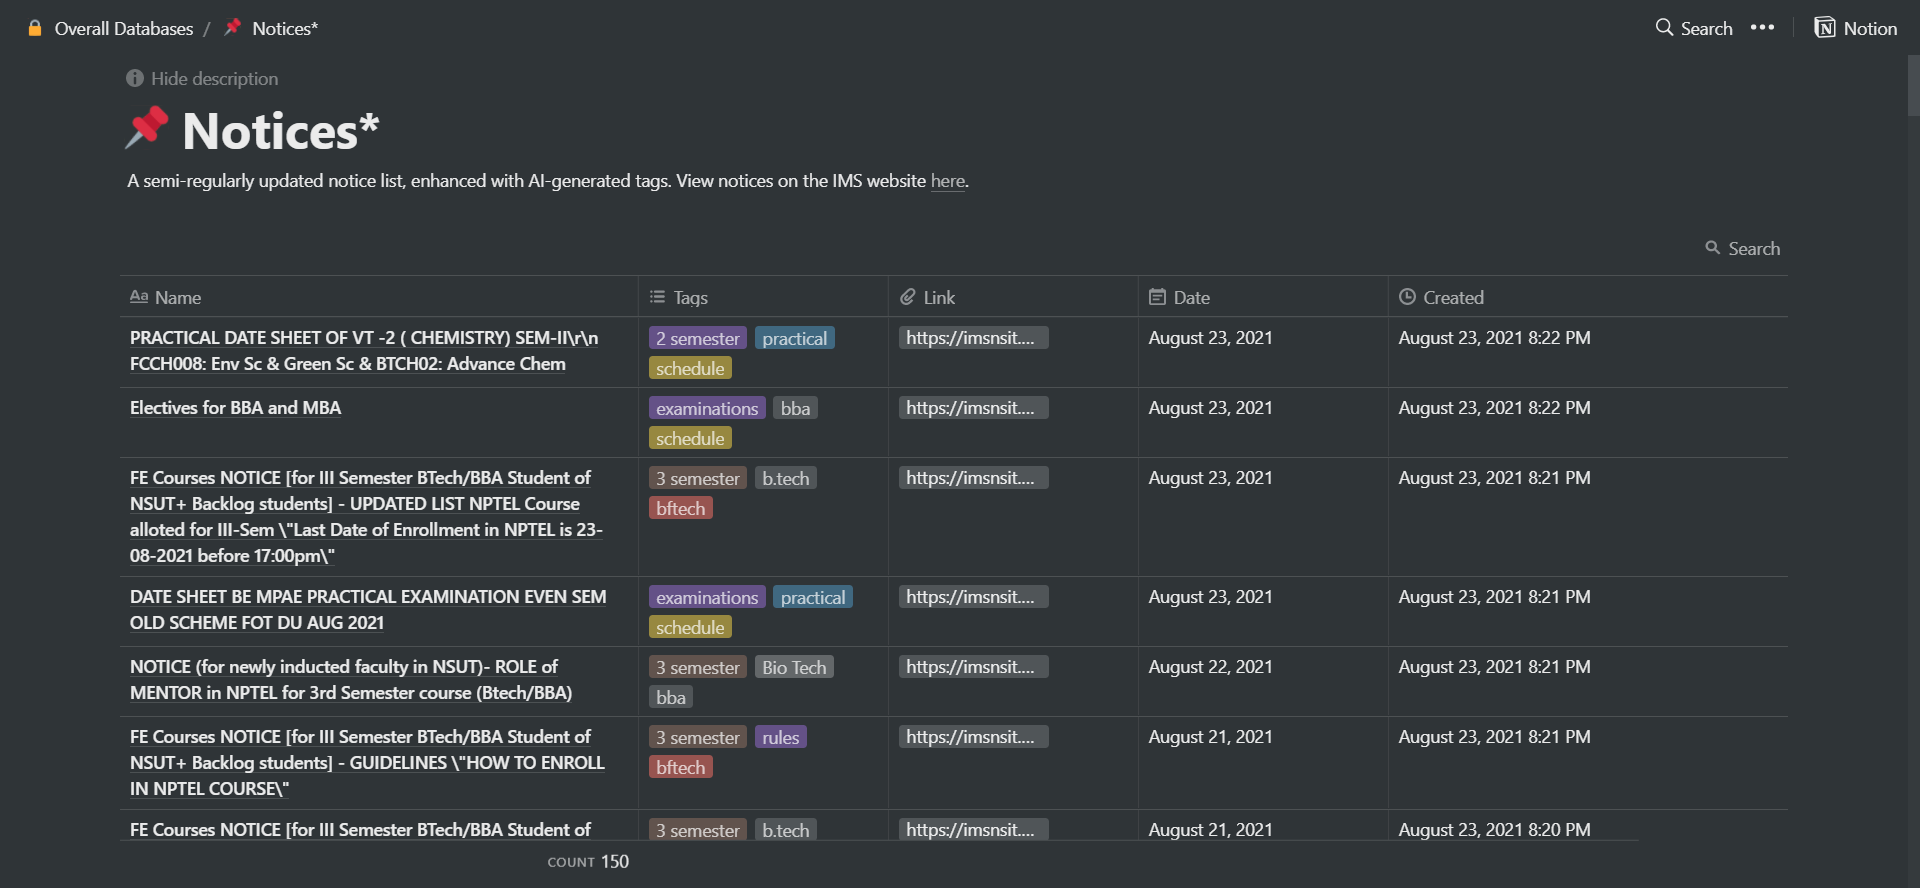